# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
#added countvectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 14, alternate_sign=False)
        #cv = CountVectorizer()
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
       # print("Shape of HashingVectorizer X:")
        print("Shape of CountVectorizer x: ")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")
    # should it be a boolean value? As str.find returns an index; how will a boolean be converted to 0 or 1
    toxic_data['occur_fuck'] =(toxic_data['comment_text'].str.lower().str.count("fuck"))
    toxic_data['occur_shit'] =(toxic_data['comment_text'].str.lower().str.count("shit"))
    toxic_data['uppercase_letters'] = toxic_data['comment_text'].str.count(r'[A-Z]')
    

    X_quant_features = toxic_data[["word_count", "occur_fuck", "uppercase_letters", "punc_count", "occur_shit"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='toxiccomments_train.csv', my_random_seed=65)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\r\nWhy the edits made under my use...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\r\nMore\r\nI can't make any real suggestions...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [1]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

NameError: name 'X_train' is not defined

### MODEL: SVM, linear

In [5]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 13071, 'Neg': 114585, 'TP': 12342, 'TN': 113878, 'FP': 707, 'FN': 729, 'Accuracy': 0.9887510183618474, 'Precision': 0.9458196030347154, 'Recall': 0.9442276795960524, 'desc': 'svm_train'}


### MODEL: logistic regression

In [6]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 13071, 'Neg': 114585, 'TP': 12340, 'TN': 113923, 'FP': 662, 'FN': 731, 'Accuracy': 0.9890878611267783, 'Precision': 0.9490847561913551, 'Recall': 0.9440746691148344, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [7]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 13071, 'Neg': 114585, 'TP': 11958, 'TN': 99754, 'FP': 14831, 'FN': 1113, 'Accuracy': 0.8751018361847465, 'Precision': 0.4463772443913547, 'Recall': 0.9148496672022034, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [8]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 13071, 'Neg': 114585, 'TP': 12175, 'TN': 113761, 'FP': 824, 'FN': 896, 'Accuracy': 0.98652628940277, 'Precision': 0.9366105085006539, 'Recall': 0.9314513044143524, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [9]:
from sklearn import linear_model
#try small numbers 0.1 or something
#try multiple ridge models
rdg01 = linear_model.RidgeClassifier()
rdg01.fit(X_train, y_train)

rdg01_performance_train = BinaryClassificationPerformance(rdg01.predict(X_train), y_train, 'rdg01_train')
rdg01_performance_train.compute_measures()
print(rdg01_performance_train.performance_measures)

{'Pos': 13071, 'Neg': 114585, 'TP': 8347, 'TN': 114183, 'FP': 402, 'FN': 4724, 'Accuracy': 0.9598452089991854, 'Precision': 0.9540518916447595, 'Recall': 0.6385892433631704, 'desc': 'rdg01_train'}


In [ ]:

#try small numbers 0.1 or something
#try multiple ridge models
rdg02 = linear_model.RidgeClassifier(alpha=0.034)
rdg02.fit(X_train, y_train)

rdg02_performance_train = BinaryClassificationPerformance(rdg02.predict(X_train), y_train, 'rdg02_train')
rdg02_performance_train.compute_measures()
print(rdg02_performance_train.performance_measures)

In [ ]:

rdg03 = linear_model.RidgeClassifier(alpha=0.15)
rdg03.fit(X_train, y_train)

rdg03_performance_train = BinaryClassificationPerformance(rdg03.predict(X_train), y_train, 'rdg03_train')
rdg03_performance_train.compute_measures()
print(rdg03_performance_train.performance_measures)


In [ ]:

rdg04 = linear_model.RidgeClassifier(alpha=0.35)
rdg04.fit(X_train, y_train)

rdg04_performance_train = BinaryClassificationPerformance(rdg04.predict(X_train), y_train, 'rdg04_train')
rdg04_performance_train.compute_measures()
print(rdg04_performance_train.performance_measures)



In [ ]:

rdg05 = linear_model.RidgeClassifier(alpha=1.25)
rdg05.fit(X_train, y_train)

rdg05_performance_train = BinaryClassificationPerformance(rdg04.predict(X_train), y_train, 'rdg05_train')
rdg05_performance_train.compute_measures()
print(rdg05_performance_train.performance_measures)



### MODEL: Random Forest Classifier

In [10]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 13071, 'Neg': 114585, 'TP': 0, 'TN': 114585, 'FP': 0, 'FN': 13071, 'Accuracy': 0.8976076330137244, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_train'}


C:\Users\jills\Documents\Machine Learning\ml\final_assignment_1\my_measures.py:25: RuntimeWarning: invalid value encountered in longlong_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### Model SVC

In [23]:
from sklearn.svm import LinearSVC 

#set alphas and arrays
C_val = [0.01, 0.0005, 0.0000001, 0.5, 0.025]
svc={}
svc_train={}


for i in range(5):
    svc[i] = LinearSVC(C=C_val[i])
    svc[i].fit(X_train, y_train)
    svc_train[i] = BinaryClassificationPerformance(svc[i].predict(X_train), y_train, (str(C_val[i])))
    svc_train[i].compute_measures()

In [24]:
for i in range(5):
    print(svc_train[i].performance_measures)

{'Pos': 13071, 'Neg': 114585, 'TP': 12414, 'TN': 114207, 'FP': 378, 'FN': 657, 'Accuracy': 0.9918922729836436, 'Precision': 0.9704502814258912, 'Recall': 0.949736056919899, 'desc': '0.01'}
{'Pos': 13071, 'Neg': 114585, 'TP': 11543, 'TN': 114009, 'FP': 576, 'FN': 1528, 'Accuracy': 0.9835182051764116, 'Precision': 0.9524713260169981, 'Recall': 0.8830999923494759, 'desc': '0.0005'}
{'Pos': 13071, 'Neg': 114585, 'TP': 596, 'TN': 114585, 'FP': 0, 'FN': 12475, 'Accuracy': 0.902276430406718, 'Precision': 1.0, 'Recall': 0.045597123402953105, 'desc': '1e-07'}
{'Pos': 13071, 'Neg': 114585, 'TP': 12061, 'TN': 113618, 'FP': 967, 'FN': 1010, 'Accuracy': 0.9845130663658582, 'Precision': 0.9257752533005834, 'Recall': 0.9227297069849285, 'desc': '0.5'}
{'Pos': 13071, 'Neg': 114585, 'TP': 12540, 'TN': 114216, 'FP': 369, 'FN': 531, 'Accuracy': 0.9929498025944726, 'Precision': 0.9714152916569835, 'Recall': 0.9593757172366307, 'desc': '0.025'}


### ROC plot to compare performance of various C values in Linear SVC

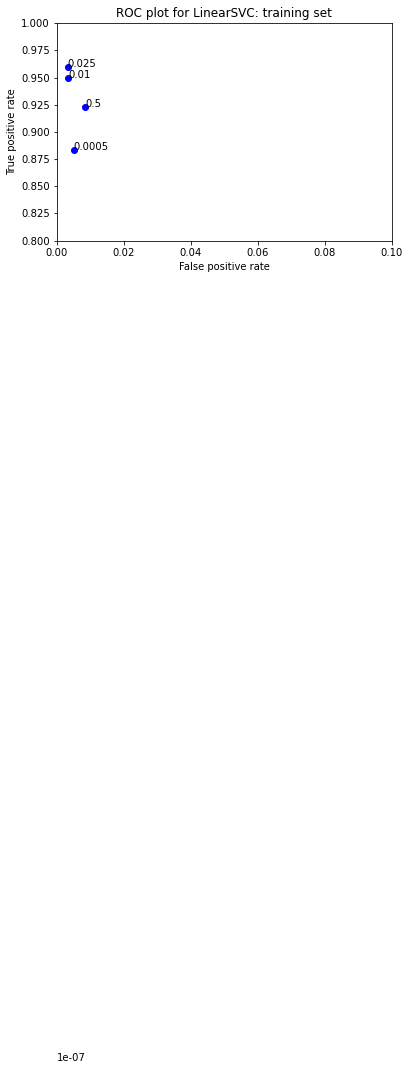

In [26]:
#fits = [rdg01_performance_train,rdg02_performance_train,rdg03_performance_train,rdg04_performance_train,rdg05_performance_train]
#fits = [rdf_performance_train,rdg02_performance_train,prc_performance_train,nbs_performance_train,lgs_performance_train,svm_performance_train,ols_performance_train]

for i in range(5):
    plt.plot(svc_train[i].performance_measures['FP'] / svc_train[i].performance_measures['Neg'], 
             svc_train[i].performance_measures['TP'] / svc_train[i].performance_measures['Pos'], 'bo')
    plt.text(svc_train[i].performance_measures['FP'] / svc_train[i].performance_measures['Neg'], 
             svc_train[i].performance_measures['TP'] / svc_train[i].performance_measures['Pos'], svc_train[i].desc)
plt.axis([0, 0.1, 0.8, 1])
plt.title('ROC plot for LinearSVC: training set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [ ]:
ols_predictions = ols.predict(X_train)

In [ ]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

In [27]:
svc_test = {}

for i in range(5):
    svc_test[i] = BinaryClassificationPerformance(svc[i].predict(X_test), y_test, (str(C_val[i])))
    svc_test[i].compute_measures()
    print(svc_test[i].performance_measures)

{'Pos': 3154, 'Neg': 28761, 'TP': 2124, 'TN': 27255, 'FP': 1506, 'FN': 1030, 'Accuracy': 0.9205389315368949, 'Precision': 0.5851239669421487, 'Recall': 0.673430564362714, 'desc': '0.01'}
{'Pos': 3154, 'Neg': 28761, 'TP': 2161, 'TN': 27822, 'FP': 939, 'FN': 993, 'Accuracy': 0.9394642017859941, 'Precision': 0.6970967741935484, 'Recall': 0.6851616994292962, 'desc': '0.0005'}
{'Pos': 3154, 'Neg': 28761, 'TP': 129, 'TN': 28760, 'FP': 1, 'FN': 3025, 'Accuracy': 0.9051856493811687, 'Precision': 0.9923076923076923, 'Recall': 0.0409004438807863, 'desc': '1e-07'}
{'Pos': 3154, 'Neg': 28761, 'TP': 2051, 'TN': 26925, 'FP': 1836, 'FN': 1103, 'Accuracy': 0.9079116402945323, 'Precision': 0.5276562901980962, 'Recall': 0.650285351934052, 'desc': '0.5'}
{'Pos': 3154, 'Neg': 28761, 'TP': 2108, 'TN': 27091, 'FP': 1670, 'FN': 1046, 'Accuracy': 0.9148989503368322, 'Precision': 0.5579671784012705, 'Recall': 0.6683576410906785, 'desc': '0.025'}


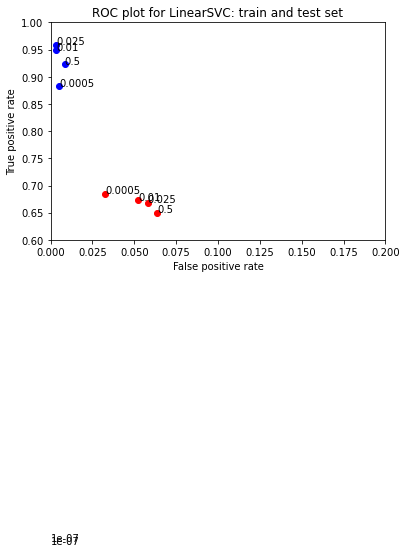

In [33]:
for i in range(5):
    plt.plot(svc_train[i].performance_measures['FP'] / svc_train[i].performance_measures['Neg'], 
             svc_train[i].performance_measures['TP'] / svc_train[i].performance_measures['Pos'], 'bo')
    plt.text(svc_train[i].performance_measures['FP'] / svc_train[i].performance_measures['Neg'], 
             svc_train[i].performance_measures['TP'] / svc_train[i].performance_measures['Pos'], svc_train[i].desc)
    plt.plot(svc_test[i].performance_measures['FP'] / svc_test[i].performance_measures['Neg'], 
             svc_test[i].performance_measures['TP'] / svc_test[i].performance_measures['Pos'], 'ro')
    plt.text(svc_test[i].performance_measures['FP'] / svc_test[i].performance_measures['Neg'], 
             svc_test[i].performance_measures['TP'] / svc_test[i].performance_measures['Pos'], svc_train[i].desc)
plt.axis([0, 0.2, 0.6, 1])
plt.title('ROC plot for LinearSVC: train and test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### MODEL: ordinary least squares

In [ ]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

### MODEL: SVM, linear

In [11]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3154, 'Neg': 28761, 'TP': 2137, 'TN': 27225, 'FP': 1536, 'FN': 1017, 'Accuracy': 0.9200062666457779, 'Precision': 0.5818132316907161, 'Recall': 0.6775523145212429, 'desc': 'svm_test'}


### MODEL: logistic regression

In [12]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3154, 'Neg': 28761, 'TP': 2117, 'TN': 27232, 'FP': 1529, 'FN': 1037, 'Accuracy': 0.9195989346702178, 'Precision': 0.5806363137685134, 'Recall': 0.6712111604311984, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [13]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3154, 'Neg': 28761, 'TP': 2307, 'TN': 24730, 'FP': 4031, 'FN': 847, 'Accuracy': 0.8471565094783018, 'Precision': 0.3639949510886715, 'Recall': 0.7314521242866202, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [14]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3154, 'Neg': 28761, 'TP': 2109, 'TN': 27239, 'FP': 1522, 'FN': 1045, 'Accuracy': 0.9195676014413285, 'Precision': 0.5808317267970257, 'Recall': 0.6686746987951807, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [15]:
rdg01_performance_test = BinaryClassificationPerformance(rdg01.predict(X_test), y_test, 'rdg01_test')
rdg01_performance_test.compute_measures()
print(rdg01_performance_test.performance_measures)

{'Pos': 3154, 'Neg': 28761, 'TP': 1745, 'TN': 28536, 'FP': 225, 'FN': 1409, 'Accuracy': 0.9488015039949866, 'Precision': 0.8857868020304569, 'Recall': 0.5532656943563729, 'desc': 'rdg01_test'}


In [ ]:
rdg02_performance_test = BinaryClassificationPerformance(rdg02.predict(X_test), y_test, 'rdg02_test')
rdg02_performance_test.compute_measures()

print(rdg02_performance_test.performance_measures)

In [ ]:
rdg03_performance_test = BinaryClassificationPerformance(rdg03.predict(X_test), y_test, 'rdg03_test')
rdg03_performance_test.compute_measures()

print(rdg03_performance_test.performance_measures)

In [ ]:
rdg04_performance_test = BinaryClassificationPerformance(rdg04.predict(X_test), y_test, 'rdg04_test')
rdg04_performance_test.compute_measures()

print(rdg04_performance_test.performance_measures)

In [ ]:
rdg05_performance_test = BinaryClassificationPerformance(rdg05.predict(X_test), y_test, 'rdg05_test')
rdg05_performance_test.compute_measures()

print(rdg05_performance_test.performance_measures)

### MODEL: Random Forest Classifier

In [ ]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

### ROC plot to compare performance of various models and fits

In [ ]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg01_performance_test, rdf_performance_test]

#fits = [rdg01_performance_test,rdg02_performance_test,rdg03_performance_test,rdg04_performance_test,rdg05_performance_test]
for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

## Comparison plots for various models

In [ ]:
fits = [ols_performance_train, svm_performance_train, 
        lgs_performance_train, nbs_performance_train, prc_performance_train, rdg01_performance_train, rdf_performance_train]
fits2 = [ols_performance_test, svm_performance_test, 
        lgs_performance_test, nbs_performance_test, prc_performance_test, rdg01_performance_test, rdf_performance_train]

plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
for fit in fits:
    plt.barh(fit.desc, fit.performance_measures['Accuracy'], color=['tab:blue'])
    plt.title('Compare Model Accuracy - Train set')

plt.subplot(1, 2, 2)
for fit in fits2:
    plt.barh(fit.desc, fit.performance_measures['Accuracy'], color=['tab:green'])
    plt.title('Compare Model Accuracy - Test set')
    
plt.tight_layout()
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [ ]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='toxiccomments_test.csv', my_random_seed=74, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [ ]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

In [ ]:
raw_data.head()

In [ ]:
my_submission.head()

In [ ]:
my_submission.shape

In [ ]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('toxiccomments_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation